# IMPORT

In [88]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk

from tkinter import ttk
from tkinter import *

# Load Datasets

In [89]:
data_path = 'datasets/Datafull terakhir test.csv'

df = pd.read_csv(data_path, sep=';')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

label_col = df.columns[-1]
coord_cols = df.columns[:-1]

if df[label_col].dtype != object:
    raise ValueError("Kolom label harus bertipe karakter")

expected_cols = []
for i in range(len(coord_cols) // 2):
    expected_cols.extend([f"{i}x", f"{i}y"])

if list(coord_cols) != expected_cols:
    raise ValueError("Nama atau urutan kolom koordinat tidak sesuai")

df[coord_cols] = df[coord_cols].apply(pd.to_numeric, errors='coerce')

num_points = len(coord_cols) // 2

print(f"Total sample    : {len(df)}")
print(f"Jumlah landmark : {num_points}")
print(f"Jumlah kelas    : {df[label_col].nunique()}")

df.head()


Total sample    : 8213
Jumlah landmark : 21
Jumlah kelas    : 24


,0x,0y,1x,1y,2x,2y,3x,3y,4x,4y,...,16y,17x,17y,18x,18y,19x,19y,20x,20y,char
0,449.429,643.857,327.271,587.170,265.731,484.233,246.689,362.602,231.657,252.290,...,480.806,582.295,427.375,587.343,339.388,547.296,415.208,536.242,454.387,NaN
1,451.351,653.700,333.252,594.944,265.111,486.310,256.936,354.813,248.984,239.251,...,491.502,598.279,438.230,609.486,345.403,559.002,414.437,543.311,457.700,A
2,457.565,692.363,335.312,635.283,267.992,518.501,261.948,388.552,264.993,288.713,...,490.838,584.324,453.037,589.529,370.452,548.982,435.461,536.997,465.605,A
3,454.034,534.794,333.222,489.421,258.394,399.013,232.771,269.755,218.668,160.658,...,358.808,537.166,308.455,531.600,212.394,505.065,284.374,499.484,329.256,A
4,449.840,545.633,327.645,504.473,256.748,405.653,228.244,273.756,210.097,166.311,...,365.462,545.115,312.461,548.587,221.122,514.636,287.484,503.828,326.010,A


In [90]:
# cek dimensi data sebelum masuk data preprocessing
df.shape

(8213, 43)

In [91]:
df.nunique() # mengecek data unique pada setiap kolom

0x      7664
0y      7917
1x      8020
1y      7989
2x      8078
2y      8049
3x      8108
3y      8069
4x      8133
4y      8104
5x      8046
5y      8036
6x      8104
6y      8062
7x      8106
7y      8076
8x      8120
8y      8098
9x      8021
9y      8020
10x     8062
10y     8046
11x     8092
11y     8093
12x     8099
12y     8121
13x     8024
13y     8011
14x     8076
14y     8060
15x     8060
15y     8062
16x     8054
16y     8090
17x     8027
17y     8024
18x     8086
18y     8080
19x     8072
19y     8088
20x     8102
20y     8117
char      24
dtype: int64

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8213 entries, 0 to 8212
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0x      8213 non-null   float64
 1   0y      8213 non-null   float64
 2   1x      8213 non-null   float64
 3   1y      8213 non-null   float64
 4   2x      8213 non-null   float64
 5   2y      8213 non-null   float64
 6   3x      8213 non-null   float64
 7   3y      8213 non-null   float64
 8   4x      8213 non-null   float64
 9   4y      8213 non-null   float64
 10  5x      8213 non-null   float64
 11  5y      8213 non-null   float64
 12  6x      8213 non-null   float64
 13  6y      8213 non-null   float64
 14  7x      8213 non-null   float64
 15  7y      8213 non-null   float64
 16  8x      8213 non-null   float64
 17  8y      8213 non-null   float64
 18  9x      8213 non-null   float64
 19  9y      8213 non-null   float64
 20  10x     8213 non-null   float64
 21  10y     8213 non-null   float64
 22  

In [93]:
df.dtypes

0x      float64
0y      float64
1x      float64
1y      float64
2x      float64
2y      float64
3x      float64
3y      float64
4x      float64
4y      float64
5x      float64
5y      float64
6x      float64
6y      float64
7x      float64
7y      float64
8x      float64
8y      float64
9x      float64
9y      float64
10x     float64
10y     float64
11x     float64
11y     float64
12x     float64
12y     float64
13x     float64
13y     float64
14x     float64
14y     float64
15x     float64
15y     float64
16x     float64
16y     float64
17x     float64
17y     float64
18x     float64
18y     float64
19x     float64
19y     float64
20x     float64
20y     float64
char     object
dtype: object

# Data PreProcessing

In [94]:
df.isna().sum() # mengecek data yang kosong
df.duplicated().sum # mengecek data yang duplikat

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
8208    False
8209    False
8210    False
8211    False
8212    False
Length: 8213, dtype: bool>

In [95]:
df = df.drop_duplicates() #menghapus data duplikat

In [96]:
def preprocess_hand_csv(df):
    df = df.copy()

    coord_cols = df.columns[:-1]
    label_col = df.columns[-1]
    num_points = len(coord_cols) // 2

    if len(coord_cols) % 2 != 0:
        raise ValueError("Jumlah kolom koordinat tidak genap")

    df[coord_cols] = df[coord_cols].interpolate(
        method='linear',
        axis=1,
        limit_direction='both'
    )

    df = df.drop_duplicates()

    df[coord_cols] = df[coord_cols].clip(lower=0)

    for i in range(num_points):
        df[f'{i}x'] = df[f'{i}x'] - df['0x']
        df[f'{i}y'] = df[f'{i}y'] - df['0y']

    def normalize_scale(row):
        coords = row[coord_cols].values.reshape(-1, 2)
        max_dist = np.max(np.linalg.norm(coords, axis=1))
        if max_dist == 0:
            return row[coord_cols]
        return row[coord_cols] / max_dist

    df[coord_cols] = df.apply(normalize_scale, axis=1)

    def normalize_rotation(row):
        coords = row[coord_cols].values.reshape(-1, 2)
        ref = coords[9]
        angle = np.arctan2(ref[1], ref[0])
        rot = np.array([
            [np.cos(-angle), -np.sin(-angle)],
            [np.sin(-angle),  np.cos(-angle)]
        ])
        rotated = coords @ rot.T
        return pd.Series(rotated.flatten(), index=coord_cols)

    df[coord_cols] = df.apply(normalize_rotation, axis=1)


    return df


In [97]:
df.shape # cek dimensi data setelah dihapus data duplikat

(8209, 43)

# Exploratory Data Analys

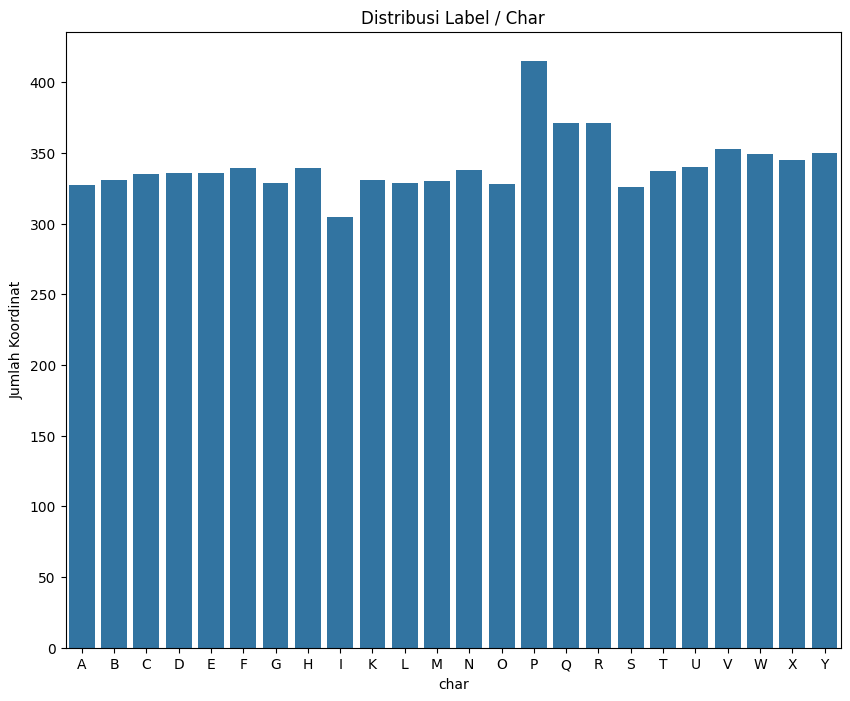

In [98]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x="char")
plt.title("Distribusi Label / Char")
plt.ylabel("Jumlah Koordinat")
plt.show()

In [99]:
def plot_sample(row): 

    x = [row[f"{i}x"] for i in range(21)]
    y = [row[f"{i}y"] for i in range(21)]

    plt.Figure(figsize=(10, 8))
    plt.plot(x, y, marker="o")
    plt.gca().invert_yaxis()
    plt.title(f"Class: {row['char']}")
    plt.show()

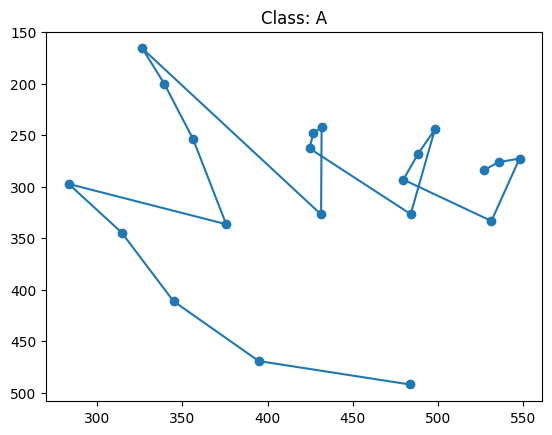

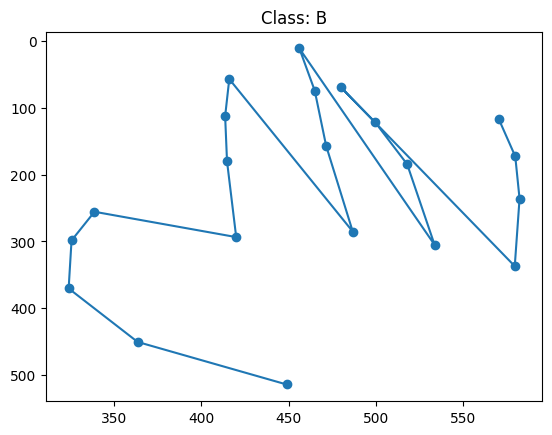

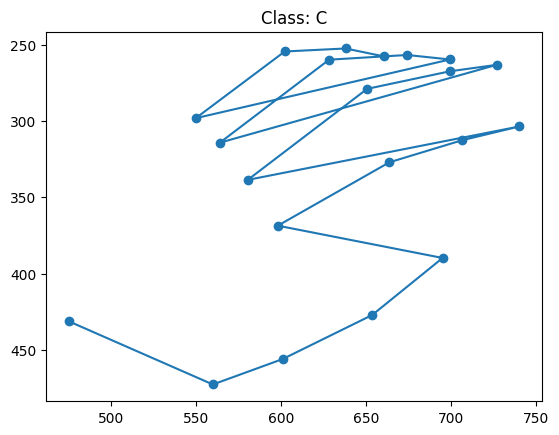

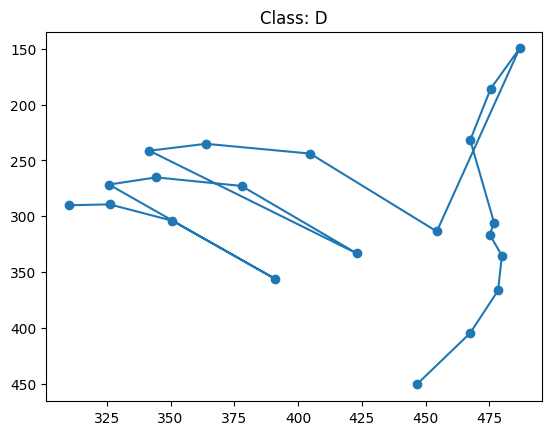

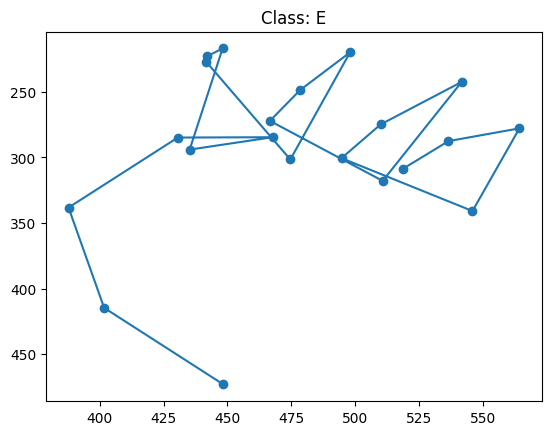

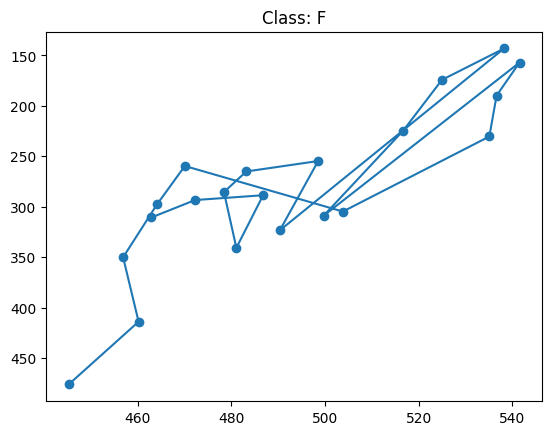

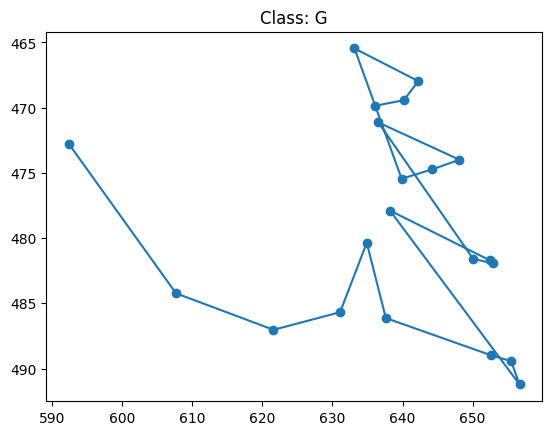

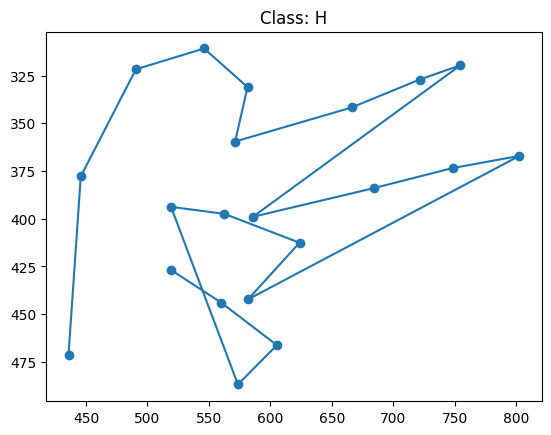

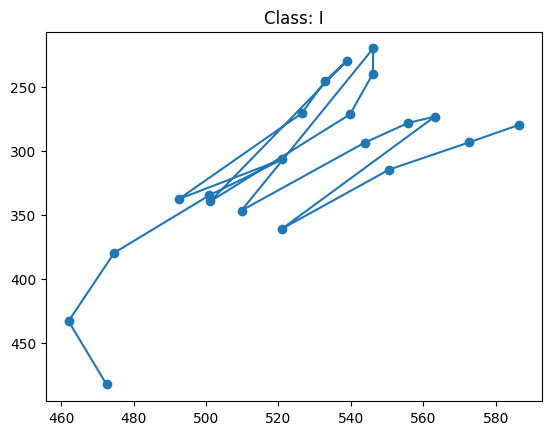

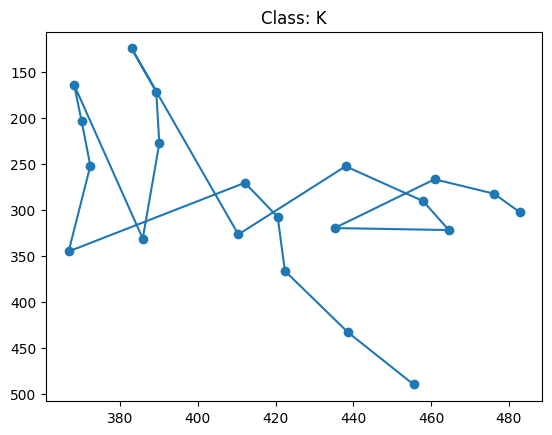

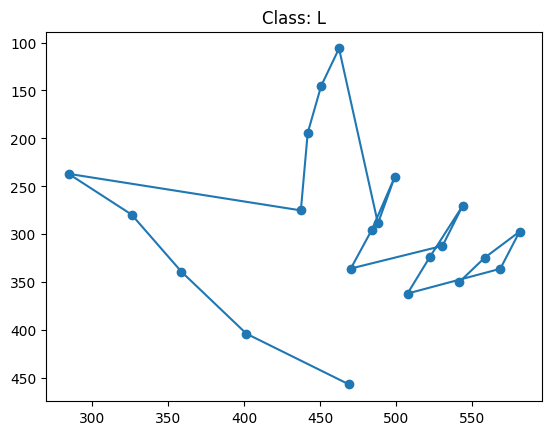

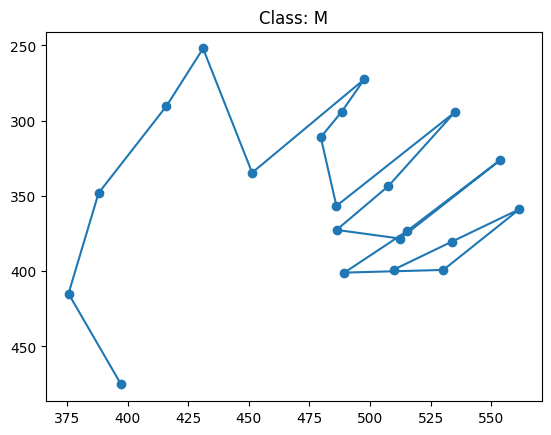

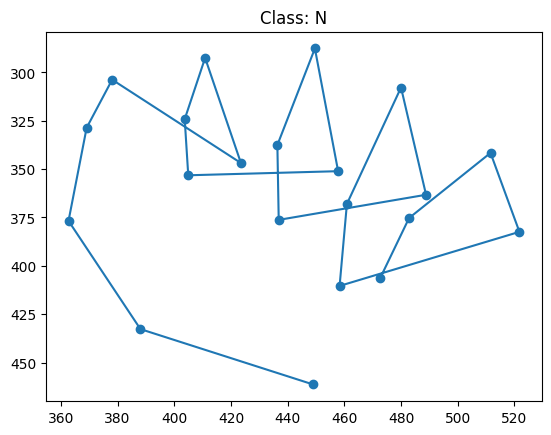

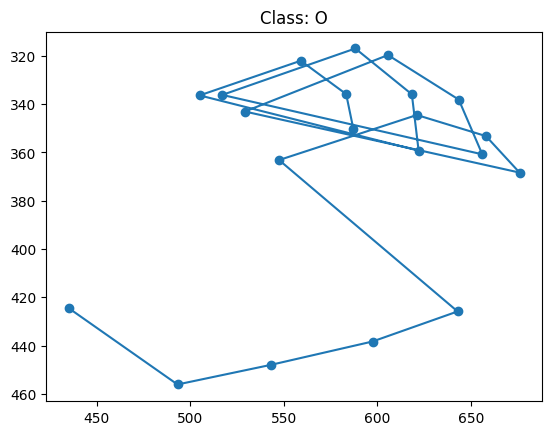

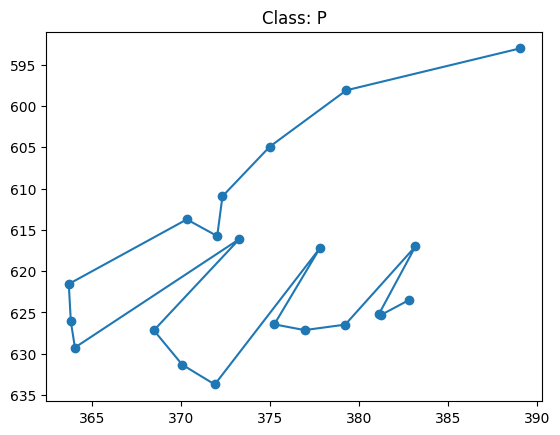

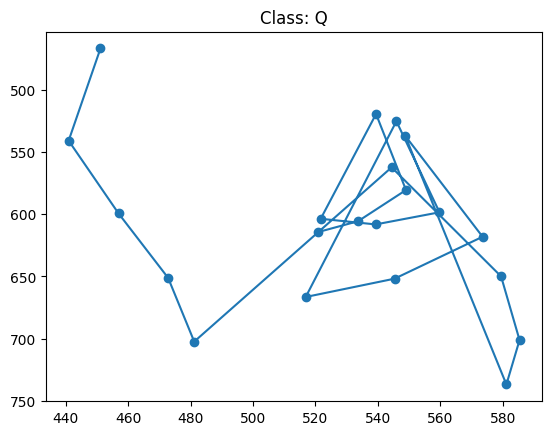

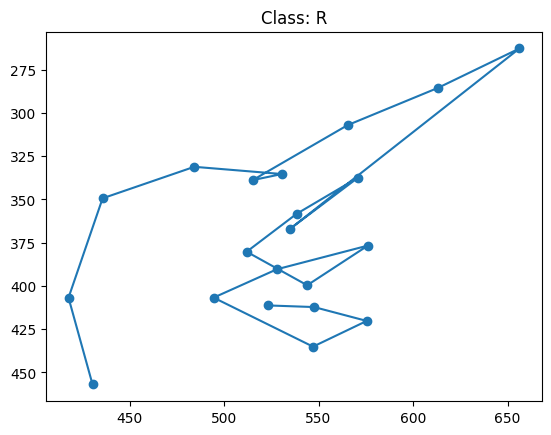

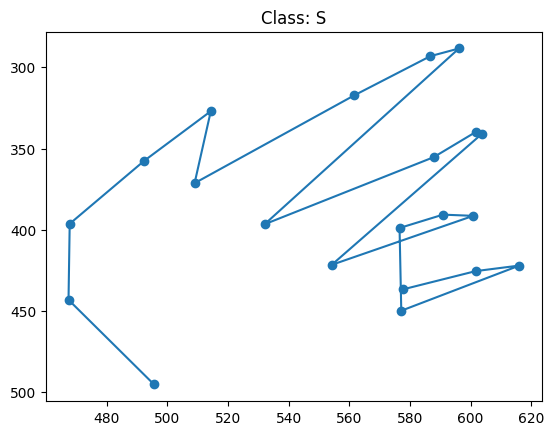

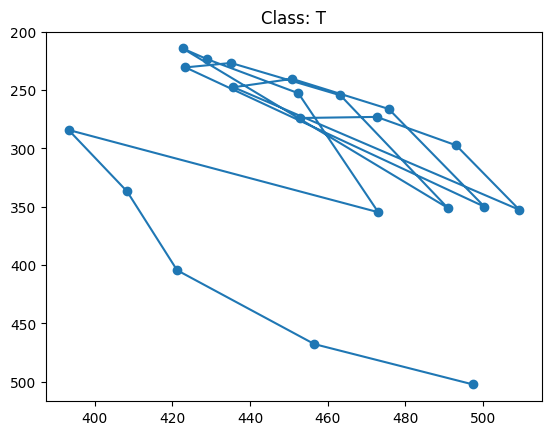

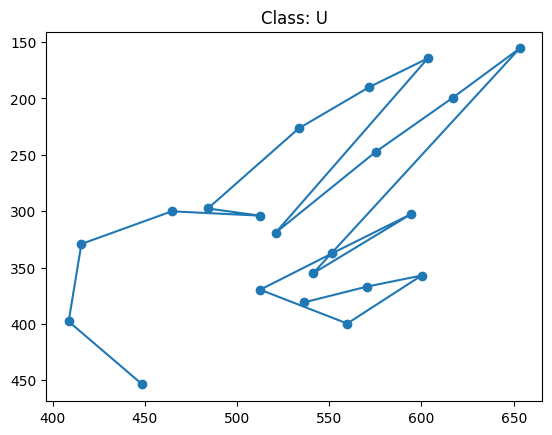

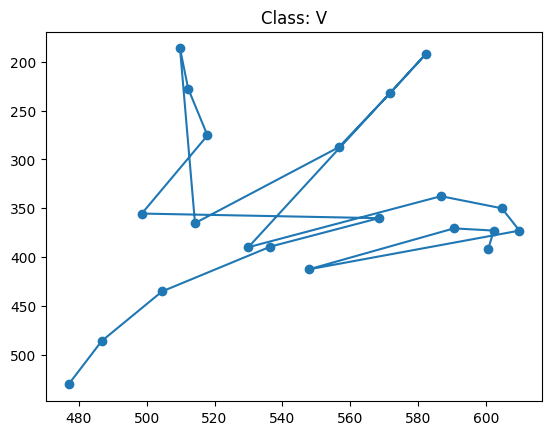

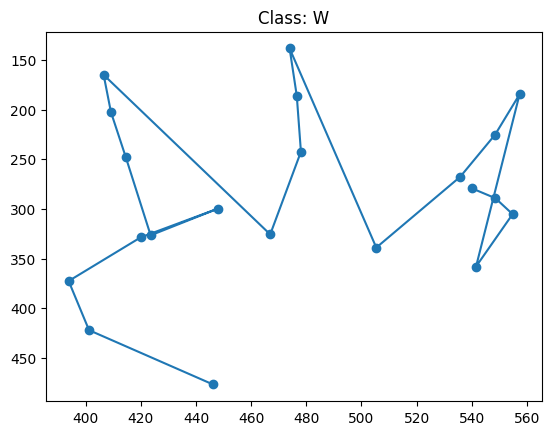

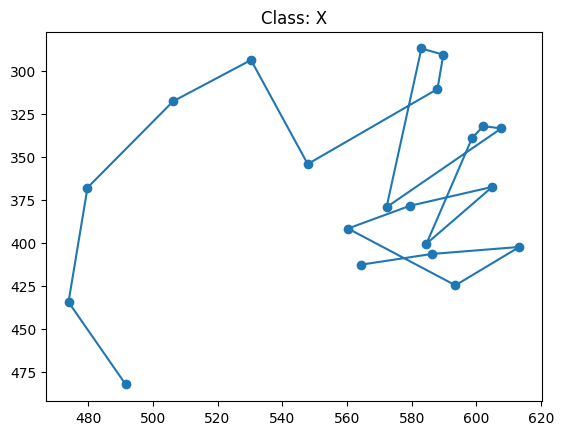

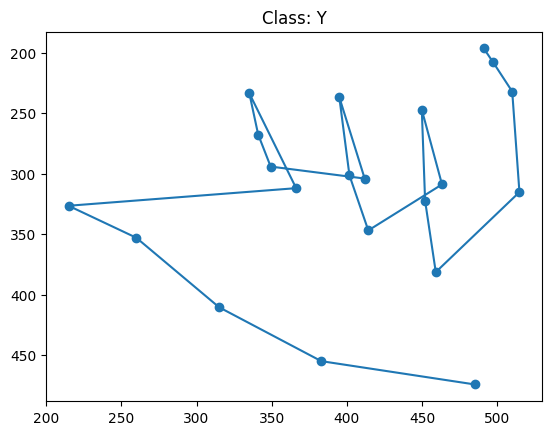

In [100]:
for label in df['char'].unique():
    subset = df[df['char'] == label]

    if subset.empty:
        continue

    sample = subset.sample(1).iloc[0]
    plot_sample(sample)


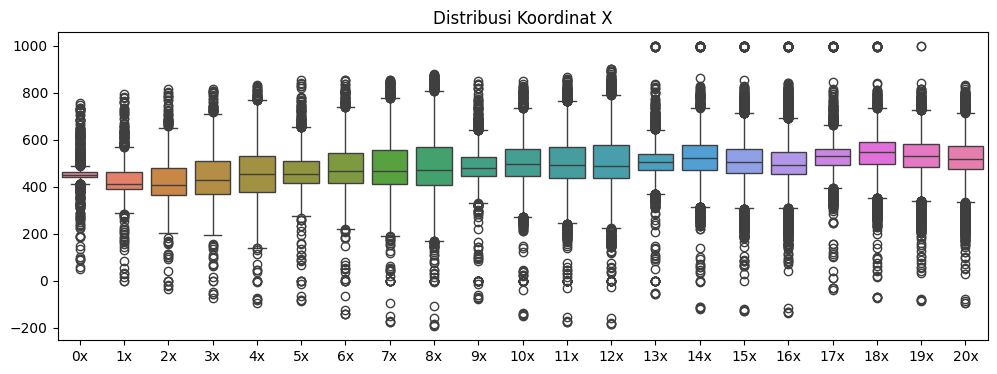

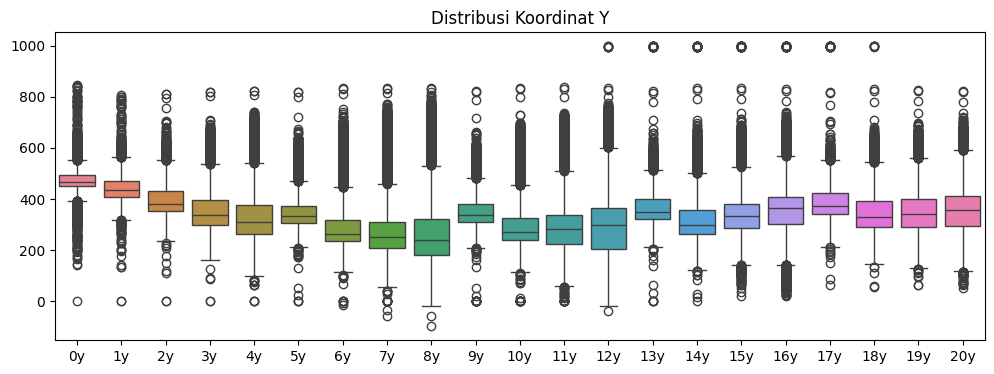

In [101]:
x_cols = [c for c in df.columns if c.endswith('x')]
y_cols = [c for c in df.columns if c.endswith('y')]

plt.figure(figsize=(12, 4))
sns.boxplot(data=df[x_cols])
plt.title("Distribusi Koordinat X")
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(data=df[y_cols])
plt.title("Distribusi Koordinat Y")
plt.show()

In [102]:
df = df[df['char'].notna()]          # buang NaN
df['char'] = df['char'].astype(str) # pastikan string
df = df[df['char'].str.match(r'^[A-Za-z]$')]
df['char'] = df['char'].str.upper()


In [103]:
print("\n=== Encoding Kolom 'char' ===")
unique_chars = sorted(df['char'].unique())
char_to_int = {char: idx for idx, char in enumerate(unique_chars)}
df['char_encoded'] = df['char'].map(char_to_int)
print("Mapping label:", char_to_int)


=== Encoding Kolom 'char' ===
Mapping label: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [104]:
df.head()

,0x,0y,1x,1y,2x,2y,3x,3y,4x,4y,...,17x,17y,18x,18y,19x,19y,20x,20y,char,char_encoded
1,451.351,653.700,333.252,594.944,265.111,486.310,256.936,354.813,248.984,239.251,...,598.279,438.230,609.486,345.403,559.002,414.437,543.311,457.700,A,0
2,457.565,692.363,335.312,635.283,267.992,518.501,261.948,388.552,264.993,288.713,...,584.324,453.037,589.529,370.452,548.982,435.461,536.997,465.605,A,0
3,454.034,534.794,333.222,489.421,258.394,399.013,232.771,269.755,218.668,160.658,...,537.166,308.455,531.600,212.394,505.065,284.374,499.484,329.256,A,0
4,449.840,545.633,327.645,504.473,256.748,405.653,228.244,273.756,210.097,166.311,...,545.115,312.461,548.587,221.122,514.636,287.484,503.828,326.010,A,0
5,463.842,550.886,334.868,506.275,258.927,407.689,242.522,275.063,240.289,165.256,...,572.307,316.280,568.785,218.200,536.225,272.665,530.120,311.422,A,0


In [105]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def _predict(self, x):
        distances = np.sqrt(np.sum((self.x_train - x) ** 2, axis=1))
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        unique, counts = np.unique(k_nearest_labels, return_counts=True)
        most_common = unique[np.argmax(counts)]
        return most_common
    
    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

In [106]:
def split_train_test(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X)
    n_test = int(n_samples * test_size)

    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


def define_conture(A):
    # ================== LOAD DATA ==================
    X_raw = df.drop(["char", "char_encoded"], axis=1).values
    y = df["char_encoded"].values

    # ================== PREPROCESS TRAIN DATA ==================
    X_processed = []
    for x in X_raw:
        x = x.reshape(1, -1)  # (1, 42)
        x_prep = preprocess_single_hand(x)
        X_processed.append(x_prep[0])  # ambil (42,)

    X = np.array(X_processed)  # (n_samples, 42)

    # ================== SPLIT ==================
    X_train, X_test, y_train, y_test = split_train_test(
        X, y, test_size=0.2, random_state=42
    )

    # ================== TRAIN ==================
    classify = KNN(k=3)
    classify.fit(X_train, y_train)

    # ================== PREPROCESS CAMERA DATA ==================
    A = preprocess_single_hand(A)  # (1, 42)

    # ================== PREDICT ==================
    pred = classify.predict(A)
    pred_label = int(pred[0])

    result_char = df.loc[df["char_encoded"] == pred_label, "char"].iloc[0]

    print("Prediksi:", result_char)
    return result_char


def preprocess_single_hand(A):
    A = A.copy()
    coords = A.reshape(-1, 2)

    # 1. Translasi (wrist = titik 0)
    coords -= coords[0]

    # 2. Normalisasi skala
    max_dist = np.max(np.linalg.norm(coords, axis=1))
    if max_dist != 0:
        coords /= max_dist

    # 3. Normalisasi rotasi
    ref = coords[9]
    angle = np.arctan2(ref[1], ref[0])

    rot = np.array(
        [[np.cos(-angle), -np.sin(-angle)], [np.sin(-angle), np.cos(-angle)]]
    )

    coords = coords @ rot.T

    return coords.flatten().reshape(1, -1)

# Pengambilan gambar handsign

In [113]:
import cv2
import numpy as np
import mediapipe as mp

# ================== MEDIAPIPE SETUP ==================
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7,
)

cap = cv2.VideoCapture(0)

print("Tekan C untuk capture, Q untuk keluar")

# ================== GET HAND LANDMARK ==================
def get_hand_points_mediapipe(frame):
    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)

    if not result.multi_hand_landmarks:
        return None, None

    hand_landmarks = result.multi_hand_landmarks[0]

    points = []
    for lm in hand_landmarks.landmark:
        x = lm.x * w
        y = lm.y * h
        points.append([x, y])

    return np.array(points, dtype=np.float32), hand_landmarks


# ================== MAIN LOOP ==================
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    points, hand_landmarks = get_hand_points_mediapipe(frame)

    if points is not None:
        # gambar skeleton (CARA BENAR)
        mp_draw.draw_landmarks(
            frame,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
        )

        # gambar index titik (debug)
        for i, (x, y) in enumerate(points):
            cv2.circle(frame, (int(x), int(y)), 4, (0, 0, 255), -1)
            cv2.putText(
                frame,
                str(i),
                (int(x) + 4, int(y) - 4),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                (255, 255, 255),
                1,
            )

    cv2.imshow("Hand Sign - MediaPipe", frame)
    key = cv2.waitKey(1) & 0xFF

    # ================== CAPTURE ==================
    if key == ord("c") and points is not None:
        A = points.flatten().reshape(1, -1)  # (1, 42)
        define_conture(A)
        break

    elif key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
hands.close()


Tekan C untuk capture, Q untuk keluar
Prediksi: L


In [108]:
# # Persiapan data
# X = df.drop(['char', 'char_encoded'], axis=1).values
# y = df['char_encoded'].values

# # csv_conture =  pd.read_csv('samples/data.csv')

# # A = np.array([csv_conture])
# # A = A.reshape(1, -1)  # Reshape A to match the input shape expected by the KNN model

# # print(X[0])

# # print(A)

# # print("Dimensi X:", X.shape)
# # print("Dimensi y:", y.shape)

# X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.2, random_state=42)

In [109]:
# classify = KNN(k=3)
# classify.fit(X_train, y_train) 

# # predictions = classify.predict(A)

# predictions= classify.predict(A)

# arr_alfa = df['char_encoded'].unique()
# alfa = df['char'].unique()

# acc = classify.accuracy(X_train, y_train)
# print(acc)

# # checking_data = zip(arr_alfa, alfa)
# # for x,y in checking_data:
# #     if x == predictions:
# #         print('benar', y)
# #     else:
# #         print('salah', y)

In [110]:
# import customtkinter as ctk

# # SETTING GLOBAL
# ctk.set_appearance_mode("light")
# ctk.set_default_color_theme("dark-blue")

# class GUI:
#     def __init__(self, root, tabCtrl):
#         self.root = root
#         self.root.geometry("800x650")
#         self.root.title("TEST GUI CUSTOMTKINTER")

#         self.tabCtrl = tabCtrl
#         self.tabCtrl.pack(fill="both", expand=True, padx=20, pady=20)

#         self.uiconfiguration()

#     def uiconfiguration(self):
#         # Membuat tab pertama (BENAR)
#         window1 = self.tabCtrl.add("Home")
#         ctk.CTkLabel(window1, text="Ini Tab Pertama").pack(pady=20)

#         window2 = self.tabCtrl.add("Transaction")
#         ctk.CTkLabel(window2, text="Ini Tab Kedua").pack(pady=20)

#         window3 = self.tabCtrl.add("Settings")
#         ctk.CTkLabel(window3, text="Ini tab ketiga").pack(pady=20)
# if __name__ == "__main__":
#     root = ctk.CTk()
#     tabCtrl = ctk.CTkTabview(root, width=700, height=500)
#     app = GUI(root, tabCtrl)
#     root.mainloop()
